# Notebook 1 - Geological Map

## Mapping Gold Deposits and Geology in Tapajós, Brazil

This notebook visualizes gold occurrences in the Tapajós region alongside simplified geological units and terrain features.

### Key Steps

- Load and reproject geological, topographic, and occurrence data.
- Group lithologies into broader categories.
- Generate hillshade from a DEM.
- Plot a composite map with gold deposits, lithology, and terrain.
- Add locator inset, scale bar, and north arrow.

All data are projected to **EPSG:4326 – WGS 84**.

Author: João Paulo Alves - joao dot guilherme dot alves @ usp dot br

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install geopandas rasterio

In [3]:
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines

import rasterio
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.plot import show as rshow

import warnings
warnings.filterwarnings("ignore")

In [4]:
VECT_DIR = "/content/drive/MyDrive/OrePredictionProject/data/vector_data"
RASTER_DIR = "/content/drive/MyDrive/OrePredictionProject/data/raster_data"
FIGS_DIR =  "/content/drive/MyDrive/OrePredictionProject/figures"

In [5]:
dem_path  = f"{RASTER_DIR}/Elev.tif"
occ_path  = f"{VECT_DIR}/GoldDeposits.gpkg"
lith_path = f"{VECT_DIR}/lithology.gpkg"
clip_path = f"{VECT_DIR}/clip_layer.gpkg"
br_path   = f"{VECT_DIR}/Brasil.gpkg"
sa_path   = f"{VECT_DIR}/SouthAmerica.gpkg"

In [6]:
crs_wgs84 = "EPSG:4326"
occ   = gpd.read_file(occ_path)
litho = gpd.read_file(lith_path)
clip  = gpd.read_file(clip_path)
br    = gpd.read_file(br_path)
sa    = gpd.read_file(sa_path)

In [7]:
litho["NOME_UNIDA"].unique()

array(['Gabro Serra Comprida', 'Quartzo - Monzogabro Igarapé Jenipapo',
       'Gabro Jutaí', 'Gabro Rio Novo', 'Granito Pepita',
       'Granito Carroçal', 'Cadiriri', 'Novo Progresso', 'Borrachudo',
       'Igarapé Ipixuna', 'Lontra', 'Curuá', 'Capoeiras', 'Alter do Chão',
       'Troctolito Cachoeira Seca',
       'Coberturas detrito-lateríticas ferruginosas',
       'Coberturas Lateríticas Imaturas', 'Aruri', 'Bom Jardim',
       'Salustiano', 'Ingarana', 'Granitos Tipo I indiferenciados',
       'Granitos Tipo A Indiferenciados', 'Creporizão', 'Maloquinha',
       'Parauari', 'Buiuçu', 'Cuiú-Cuiú', 'Castelo dos Sonhos',
       'Sai Cinza', 'Granito Igarapé Escondido', 'Granito Porquinho',
       'Depósitos aluvionares', 'Depósitos de turfas', 'Iriri',
       'Alto Tapajós'], dtype=object)

In [8]:
# Simplifying the units to generate a smaller legend

to_group_en = {
    # 1. Mafic / ultramafic intrusions
    "Gabro Serra Comprida"                  : "Mafic intrusions",
    "Gabro Jutaí"                           : "Mafic intrusions",
    "Gabro Rio Novo"                        : "Mafic intrusions",
    "Igarapé Ipixuna"                       : "Mafic intrusions",
    "Quartzo - Monzogabro Igarapé Jenipapo" : "Mafic intrusions",
    "Troctolito Cachoeira Seca"             : "Mafic intrusions",

    # 2. A-type / alkaline granites
    "Granito Pepita"                        : "A-type granites",
    "Granito Carroçal"                      : "A-type granites",
    "Granito Igarapé Escondido"             : "A-type granites",
    "Granito Porquinho"                     : "A-type granites",
    "Granitos Tipo A Indiferenciados"       : "A-type granites",

    # 3. I-type granites (Parauari arc)
    "Parauari"                              : "I-type granites",
    "Buiuçu"                                : "I-type granites",
    "Bom Jardim"                            : "I-type granites",
    "Cuiú-Cuiú"                             : "I-type granites",
    "Granitos Tipo I indiferenciados"       : "I-type granites",

    # 4. Metavolcano-sedimentary sequences (greenstone belts)
    "Creporizão"                            : "Greenstone sequences",
    "Maloquinha"                            : "Greenstone sequences",
    "Cadiriri"                              : "Greenstone sequences",
    "Novo Progresso"                        : "Greenstone sequences",
    "Borrachudo"                            : "Greenstone sequences",
    "Lontra"                                : "Greenstone sequences",
    "Curuá"                                 : "Greenstone sequences",
    "Capoeiras"                             : "Greenstone sequences",
    "Ingarana"                              : "Greenstone sequences",
    "Salustiano"                            : "Greenstone sequences",

    # 5. Archean basement (gneiss-granite domains)
    "Aruri"                                 : "Archean basement",
    "Alto Tapajós"                          : "Archean basement",

    # 6. Paleoproterozoic rift sediments (Cds / Sai Cinza)
    "Castelo dos Sonhos"                    : "Rift-related sediments",
    "Sai Cinza"                             : "Rift-related sediments",

    # 7. Cretaceous sediments
    "Alter do Chão"                         : "Cretaceous sediments",

    # 8. Lateritic regolith
    "Coberturas detrito-lateríticas ferruginosas" : "Lateritic regolith",
    "Coberturas Lateríticas Imaturas"             : "Lateritic regolith",

    # 9. Quaternary surficial deposits
    "Depósitos aluvionares"                 : "Quaternary deposits",
    "Depósitos de turfas"                   : "Quaternary deposits",

    # 10. Volcano-sedimentary sequences
    "Iriri"                                 : "Volcano-sedimentary sequences",
}


litho["GROUP_EN"] = litho["NOME_UNIDA"].map(to_group_en)

In [9]:
# Creating a custom qualitative colormap

lith_colors = {
    "Mafic intrusions"             : "#006400",
    "A-type granites"              : "#b2182b",
    "I-type granites"              : "#8c510a",
    "Greenstone sequences"         : "#2CA25F",
    "Archean basement"             : "#bdbdbd",
    "Rift-related sediments"       : "#ffd92f",
    "Cretaceous sediments"         : "#d9b38c",
    "Lateritic regolith"           : "#e6550d",
    "Quaternary deposits"          : "#fddbc7",
    "Volcano-sedimentary sequences": "#6a3d9a"
}

In [10]:
# Ensure ordering is stable
order = [
    "Mafic intrusions", "A-type granites", "I-type granites",
    "Greenstone sequences", "Archean basement", "Rift-related sediments",
    "Cretaceous sediments", "Lateritic regolith",
    "Quaternary deposits", "Volcano-sedimentary sequences"
]

# Map GROUP_EN to hex
litho["color"] = litho["GROUP_EN"].map(lith_colors)

In [11]:
# Creating hillshade

with rasterio.open(dem_path) as src:
    target_res = 0.0025                # ~275 m
    dst_aff, dst_W, dst_H = calculate_default_transform(
        src.crs, crs_wgs84, src.width, src.height,
        *src.bounds, resolution=target_res
    )
    dem_wgs = np.empty((dst_H, dst_W), dtype="float32")

    reproject(
        source=rasterio.band(src, 1), destination=dem_wgs,
        src_transform=src.transform, src_crs=src.crs,
        dst_transform=dst_aff, dst_crs=crs_wgs84,
        resampling=Resampling.bilinear
    )

In [12]:
res_lon, res_lat = dst_aff.a, -dst_aff.e
dx, dy  = np.gradient(dem_wgs, res_lon, res_lat)
slope   = np.pi/2 - np.arctan(np.hypot(dx, dy))
aspect  = np.arctan2(-dx, dy)
az, zen = np.deg2rad(315), np.deg2rad(60)          # sun in higher position
hs      = np.sin(zen)*np.sin(slope) + np.cos(zen)*np.cos(slope)*np.cos(az - aspect)
hs      = np.clip(hs, 0, 1) ** 0.6

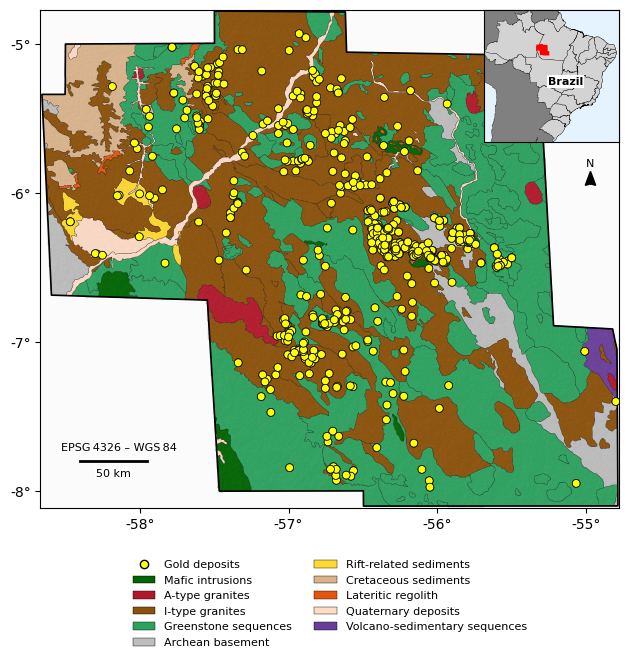

In [13]:
fig = plt.figure(figsize=(8, 6))
ax_main  = fig.add_axes([0.05, 0.05, 0.9, 0.83])   # main map
ax_inset = fig.add_axes([0.642, 0.66, 0.27, 0.22])  # inset map

rshow(hs, transform=dst_aff, ax=ax_main,
      cmap="Greys_r", alpha=0.45, zorder=0)

field = "GROUP_EN"

litho.plot(
    ax=ax_main,
    color=litho["color"],
    edgecolor="k", linewidth=0.15,
    alpha=0.95, legend=False
)

clip.boundary.plot(ax=ax_main, edgecolor="k", linewidth=1.2, zorder=3)
occ.plot(ax=ax_main, marker="o", color="yellow", edgecolor="black",
         linewidth=0.4, markersize=30, zorder=4,
         path_effects=[pe.withStroke(linewidth=0.8, foreground="black")])

# Coordinates of the bar (in map units)
bar_start_x = -58.4
bar_start_y = -7.8
bar_length = 0.45  # roughly ~50 km at the equator

# Scale bar line
ax_main.add_line(mlines.Line2D([bar_start_x, bar_start_x + bar_length],
                                [bar_start_y, bar_start_y],
                                color='black', linewidth=2, zorder=5))

# Text above or below the scale bar
ax_main.text(bar_start_x + bar_length / 2, bar_start_y - 0.05,
             '50 km', ha='center', va='top', fontsize=8,
             bbox=dict(facecolor='white', edgecolor='none', pad=1), zorder=5)

ax_main.text(0.036, 0.11, "EPSG 4326 – WGS 84",
             transform=ax_main.transAxes,
             ha="left", va="bottom", fontsize=8)

nx, ny = 0.95, 0.65                    # arrow
ax_main.text(nx, ny + 0.03, "N",
             transform=ax_main.transAxes,
             fontsize=8, ha="center", va="bottom", zorder=6)
ax_main.arrow(nx, ny, 0, 0.025,
              transform=ax_main.transAxes,
              length_includes_head=True,
              head_width=0.018, head_length=0.028,
              overhang=0.1, facecolor="k", zorder=6)

xmin, ymin, xmax, ymax = clip.total_bounds
pad = 0.01

ax_main.set_aspect("equal")
xt = np.arange(np.floor(xmin-pad), np.ceil(xmax+pad)+1, 1)
yt = np.arange(np.floor(ymin-pad), np.ceil(ymax+pad)+1, 1)
ax_main.set_xticks(xt); ax_main.set_yticks(yt)
ax_main.set_xticklabels([f"{x:.0f}°" for x in xt])
ax_main.set_yticklabels([f"{y:.0f}°" for y in yt])

# limits of the main map
ax_main.set_xlim(xmin-pad, xmax+pad)
ax_main.set_ylim(ymin-pad, ymax+pad)

# limits of the inset map
ax_inset.set_facecolor("#e5f3ff")
sa.boundary.plot(ax=ax_inset, edgecolor="black", facecolor='gray', linewidth=0.2, zorder=1)
br.boundary.plot(ax=ax_inset, edgecolor="black", facecolor='lightgray', linewidth=0.2, zorder=2)
clip.boundary.plot(ax=ax_inset, edgecolor="red", facecolor='red', linewidth=0.2, zorder=3)
ax_inset.text(x=-55, y=-16.8, s='Brazil', fontsize=8, fontweight='bold',
              bbox=dict(facecolor='white', edgecolor='none', pad=1), zorder=4)

# zooming in Brazil
bxmin, bymin, bxmax, bymax = br.total_bounds
ax_inset.set_xlim(bxmin, bxmax-5)
ax_inset.set_ylim(bymin, bymax)
ax_inset.set_xticks([]); ax_inset.set_yticks([])
ax_inset.set_aspect("equal")

# legend of the gold deposits
gold_leg = Line2D([], [], marker='o', color='yellow', mec='black',
                  markersize=6, lw=0, label="Gold deposits")

# legend geo units
unique_units = litho[field].unique()

order = list(lith_colors)
patches = [Patch(facecolor=lith_colors[g], edgecolor="k", lw=0.3, label=g)
           for g in order]

fig.legend(handles=[gold_leg, *patches],
           loc="lower center", ncol=2, fontsize=8,
           frameon=False, bbox_to_anchor=(0.5, -0.2))

plt.tight_layout()
plt.savefig(f"{FIGS_DIR}/fig1.jpg",
            bbox_inches="tight", facecolor="w", dpi=600)
plt.show()